In [1]:
from BRScraper import nba
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

Initial data set: yearly player stats for all retired players in seasons 1999-00 to 2001-02

In [2]:
def get_individual_stats(desired_seasons):
    
    df_stats = pd.DataFrame()
    
    for desired_season in desired_seasons:
        # Stats for S-1
        per_game = nba.get_stats(desired_season, info='per_game', rename=True)
        totals = nba.get_stats(desired_season, info='totals', rename=True)
        avancados = nba.get_stats(desired_season, info='advanced', rename=True)

        # Droping repeated variables
        totals = totals.drop(['Pos','Age','G','GS','Season'], axis=1).reset_index(drop=True)
        avancados = avancados.drop(['Pos','Age','G','MP_advanced','Season'], axis=1).reset_index(drop=True)

        cols = ['Player','Season','Pos','Age','Tm','G','GS']

        # Defining variables type
        for coluna in per_game.columns:
            if coluna not in cols:
                per_game[coluna] = per_game[coluna].astype(float)
        for coluna in totals.columns:
            if coluna not in cols:
                totals[coluna] = totals[coluna].astype(float)
        for coluna in avancados.columns:
            if coluna not in cols:
                avancados[coluna] = avancados[coluna].astype(float)

        times = per_game.drop_duplicates(subset=['Player'],keep='last').reset_index(drop=True)
        times = times['Tm']

        per_game = per_game.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        totals = totals.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        avancados = avancados.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)

        per_game['Tm'] = times
        totals['Tm'] = times
        avancados['Tm'] = times

        # Merging the bases
        stats = per_game.merge(avancados, on=['Player','Tm'], how='left', validate='1:1')
        stats = stats.merge(totals, on=['Player','Tm'], how='left', validate='1:1').fillna(0)

        stats = stats.astype({'G':int,'GS':int,'Age':int})

        # Normalizing names
        stats['Player'] = stats['Player'].str.replace('.','')
        stats['Player'] = stats['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        # Trying to match Jrs
        stats['Player'] = stats['Player'].apply(lambda x: x.replace(' Jr', '') if x.endswith(' Jr') and x not in ['Jaren Jackson Jr', 'Tim Hardaway Jr', 'Gary Trent Jr', 'Larry Nance Jr',
                                                                                                                 'Duane Washington Jr', 'Scottie Pippen Jr', 'Vince Williams Jr', 'Ron Harper Jr'] else x)    
        df_stats = pd.concat([df_stats, stats], ignore_index=True)
    
    df_stats = df_stats.rename(columns={'Season':'Season S-1'})
    
    return df_stats
    

Note: On the morning of April 29, BRscraper began to work improperly and the nba.get_stats() funciton broke. I'm using a dataset I loaded on April 28 instead.

In [3]:
desired_seasons = ['2000-01','2001-02','2002-03']

initial_stats = pd.read_csv('stats.csv')

initial_stats


,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,...,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals,PG,SG,SF,PF,C
0,Tariq Abdul-Wahad,25,DEN,61,56,25.9,4.5,10.6,0.424,0.0,...,59.0,28.0,106.0,147.0,697.0,0,1,0,0,0
1,Shareef Abdur-Rahim,23,VAN,82,82,39.3,7.2,15.6,0.465,0.4,...,89.0,87.0,249.0,244.0,1663.0,0,0,1,0,0
2,Cory Alexander,26,DEN,29,2,11.3,1.0,3.4,0.286,0.3,...,24.0,2.0,28.0,39.0,82.0,1,0,0,0,0
3,Ray Allen,24,MIL,82,82,37.4,7.8,17.2,0.455,2.1,...,110.0,19.0,183.0,187.0,1809.0,0,1,0,0,0
4,Rafer Alston,23,MIL,27,0,13.4,1.0,3.5,0.284,0.1,...,12.0,0.0,29.0,29.0,60.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,Kevin Willis,39,HOU,52,5,16.6,2.4,5.5,0.440,0.0,...,25.0,23.0,41.0,98.0,315.0,0,0,0,1,0
1316,Loren Woods,23,MIN,60,0,8.6,0.6,1.6,0.344,0.0,...,17.0,34.0,36.0,60.0,110.0,0,0,0,0,1
1317,Metta World Peace,22,IND,55,50,29.9,4.9,11.6,0.423,1.0,...,141.0,39.0,118.0,217.0,727.0,0,0,1,0,0
1318,Lorenzen Wright,26,MEM,43,33,29.1,5.2,11.3,0.459,0.0,...,30.0,23.0,72.0,126.0,516.0,0,0,0,0,1


Now, we want to find data for years left in the nba for each player.

In [4]:
#using a data set of nba player career stats from kaggle: https://www.kaggle.com/datasets/justinas/nba-players-data
all_seasons = pd.read_csv('all_seasons.csv')
def seasons_played_after(player_name, input_season, all_data):
    # Filter the DataFrame for the specified player
    player_data = all_data[all_data['player_name'] == player_name]

    # Assuming the 'Season' column exists and is correctly formatted (e.g., '1999-00')
    player_data['Season_start'] = player_data['season'].apply(lambda x: int(x[:4]))

    # Calculate the start year of the input season
    input_season_start_year = int(input_season[:4])

    # Filter the data to include only seasons after the input season
    future_seasons = player_data[player_data['Season_start'] > input_season_start_year]

    # Calculate the number of unique seasons played after the input season
    num_seasons_after = len(future_seasons['Season_start'].unique())

    return num_seasons_after

updated_stats = initial_stats

updated_stats['years_left'] = initial_stats.apply(lambda row: seasons_played_after(row['Player'], row['Season'], all_seasons), axis=1)
updated_stats = updated_stats[updated_stats['years_left'] > 0]


    # Save the updated DataFrame to a new CSV file
updated_stats.to_csv('updated_stats.csv', index=False)
updated_stats

,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,...,BLK_totals,TOV_totals,PF_totals,PTS_totals,PG,SG,SF,PF,C,years_left
0,Tariq Abdul-Wahad,25,DEN,61,56,25.9,4.5,10.6,0.424,0.0,...,28.0,106.0,147.0,697.0,0,1,0,0,0,3
1,Shareef Abdur-Rahim,23,VAN,82,82,39.3,7.2,15.6,0.465,0.4,...,87.0,249.0,244.0,1663.0,0,0,1,0,0,8
2,Cory Alexander,26,DEN,29,2,11.3,1.0,3.4,0.286,0.3,...,2.0,28.0,39.0,82.0,1,0,0,0,0,2
3,Ray Allen,24,MIL,82,82,37.4,7.8,17.2,0.455,2.1,...,19.0,183.0,187.0,1809.0,0,1,0,0,0,14
4,Rafer Alston,23,MIL,27,0,13.4,1.0,3.5,0.284,0.1,...,0.0,29.0,29.0,60.0,1,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,Corliss Williamson,28,DET,78,7,21.8,5.3,10.3,0.510,0.0,...,26.0,137.0,226.0,1063.0,0,0,1,0,0,5
1315,Kevin Willis,39,HOU,52,5,16.6,2.4,5.5,0.440,0.0,...,23.0,41.0,98.0,315.0,0,0,0,1,0,4
1316,Loren Woods,23,MIN,60,0,8.6,0.6,1.6,0.344,0.0,...,34.0,36.0,60.0,110.0,0,0,0,0,1,5
1317,Metta World Peace,22,IND,55,50,29.9,4.9,11.6,0.423,1.0,...,39.0,118.0,217.0,727.0,0,0,1,0,0,14


Exploratory Data Analysis

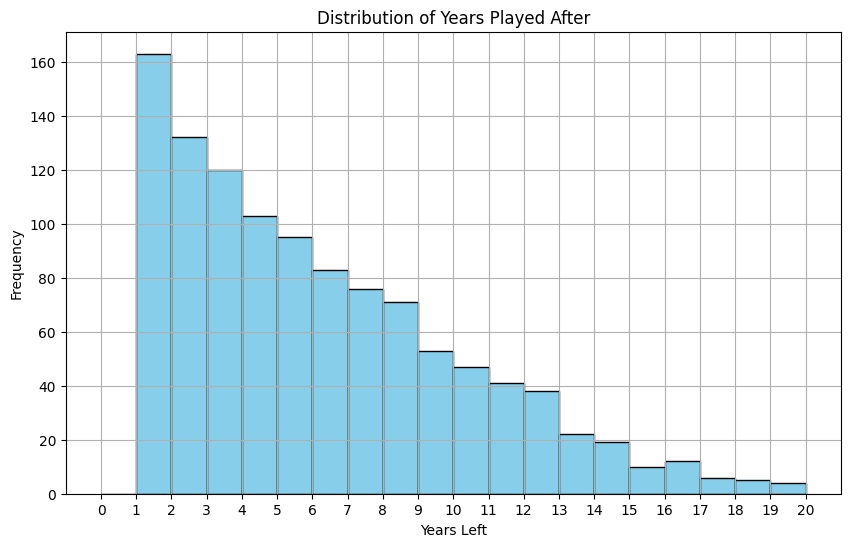

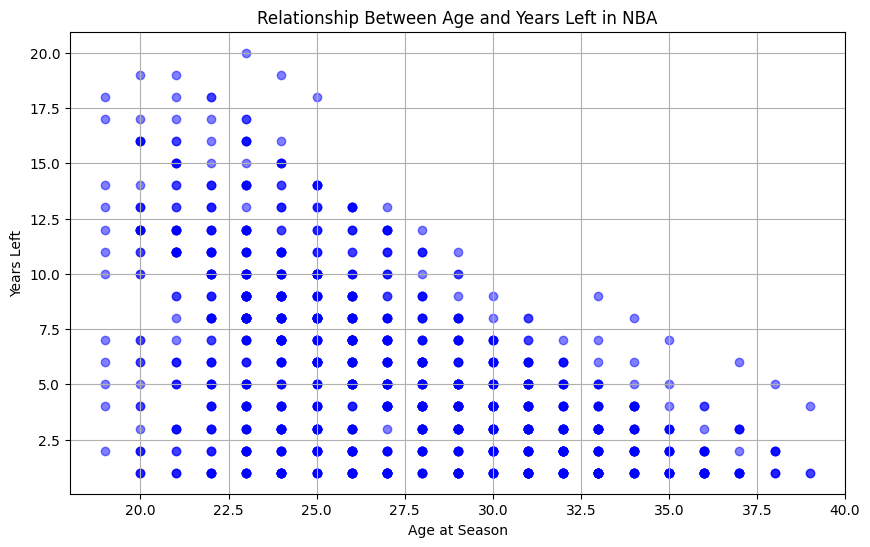

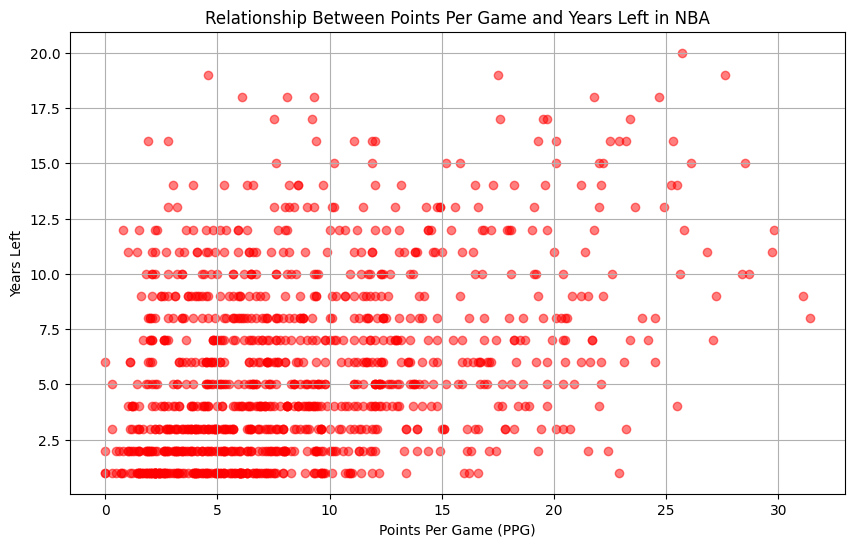

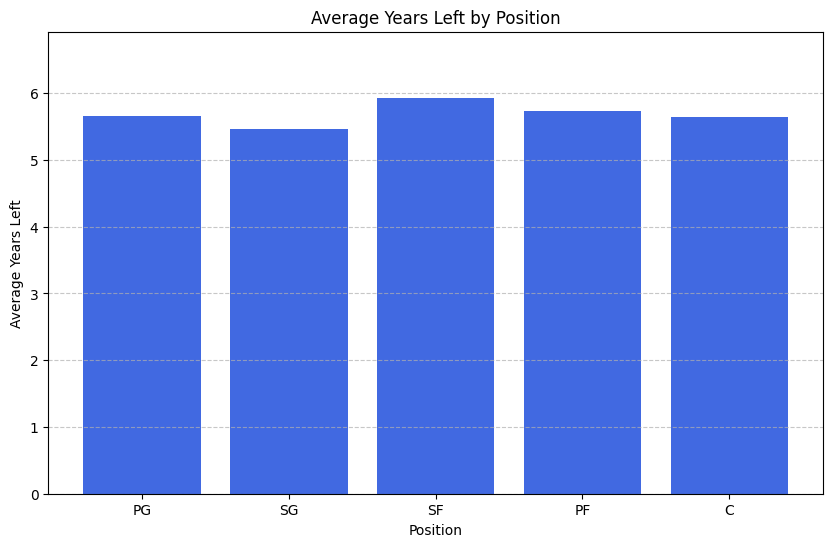

In [5]:
# Plotting the distribution of years remaining
# Plotting the distribution of 'years_played_after'
plt.figure(figsize=(10, 6))
plt.hist(updated_stats['years_left'], bins=range(0, updated_stats['years_left'].max() + 1), edgecolor='black', color='skyblue')
plt.title('Distribution of Years Played After')
plt.xlabel('Years Left')
plt.ylabel('Frequency')
plt.xticks(range(0, updated_stats['years_left'].max() + 1))
plt.grid(True)
plt.show()

# Create a scatter plot of 'Age' vs 'years_played_after'
plt.figure(figsize=(10, 6))
plt.scatter(updated_stats['Age'], updated_stats['years_left'], alpha=0.5, color='blue')
plt.title('Relationship Between Age and Years Left in NBA')
plt.xlabel('Age at Season')
plt.ylabel('Years Left')
plt.grid(True)
plt.show()

# PPG vs years_played_after
plt.figure(figsize=(10, 6))
plt.scatter(updated_stats['PTS_per_game'], updated_stats['years_left'], alpha=0.5, color='red')
plt.title('Relationship Between Points Per Game and Years Left in NBA')
plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Years Left')
plt.grid(True)
plt.show()

#Avg years left by position
positions = ['PG', 'SG', 'SF', 'PF', 'C']
# Prepare a dictionary to store average years played after by position
avg_years_left_by_pos = {}

# Compute the average for each position
for pos in positions:
    # Filter data for the current position
    pos_data = updated_stats[updated_stats[pos] == 1]
    # Calculate the average years played after
    avg_years_left_by_pos[pos] = pos_data['years_left'].mean()

# Plotting the averages
plt.figure(figsize=(10, 6))
plt.bar(avg_years_left_by_pos.keys(), avg_years_left_by_pos.values(), color='royalblue')
plt.title('Average Years Left by Position')
plt.xlabel('Position')
plt.ylabel('Average Years Left')
plt.ylim(0, max(avg_years_left_by_pos.values()) + 1)  # Setting y limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Modeling

In [6]:
X = updated_stats.drop(['Player', 'Tm', 'Season', 'years_left'], axis=1)
y = updated_stats['years_left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune these hyperparameters
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the mean squared error and the R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('RandomForrest Model')
print("Rt Mean Squared Error:", np.sqrt(mse))
print("R^2 Score:", r2)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

RandomForrest Model
Rt Mean Squared Error: 2.57611152826515
R^2 Score: 0.5914623657919862
               importance
Age              0.305777
WS_advanced      0.060047
PER_advanced     0.054333
OBPM_advanced    0.024045
BPM_advanced     0.020967
...                   ...
3P_per_game      0.002177
SF               0.001552
PF               0.001507
PG               0.000369
C                0.000320

[74 rows x 1 columns]


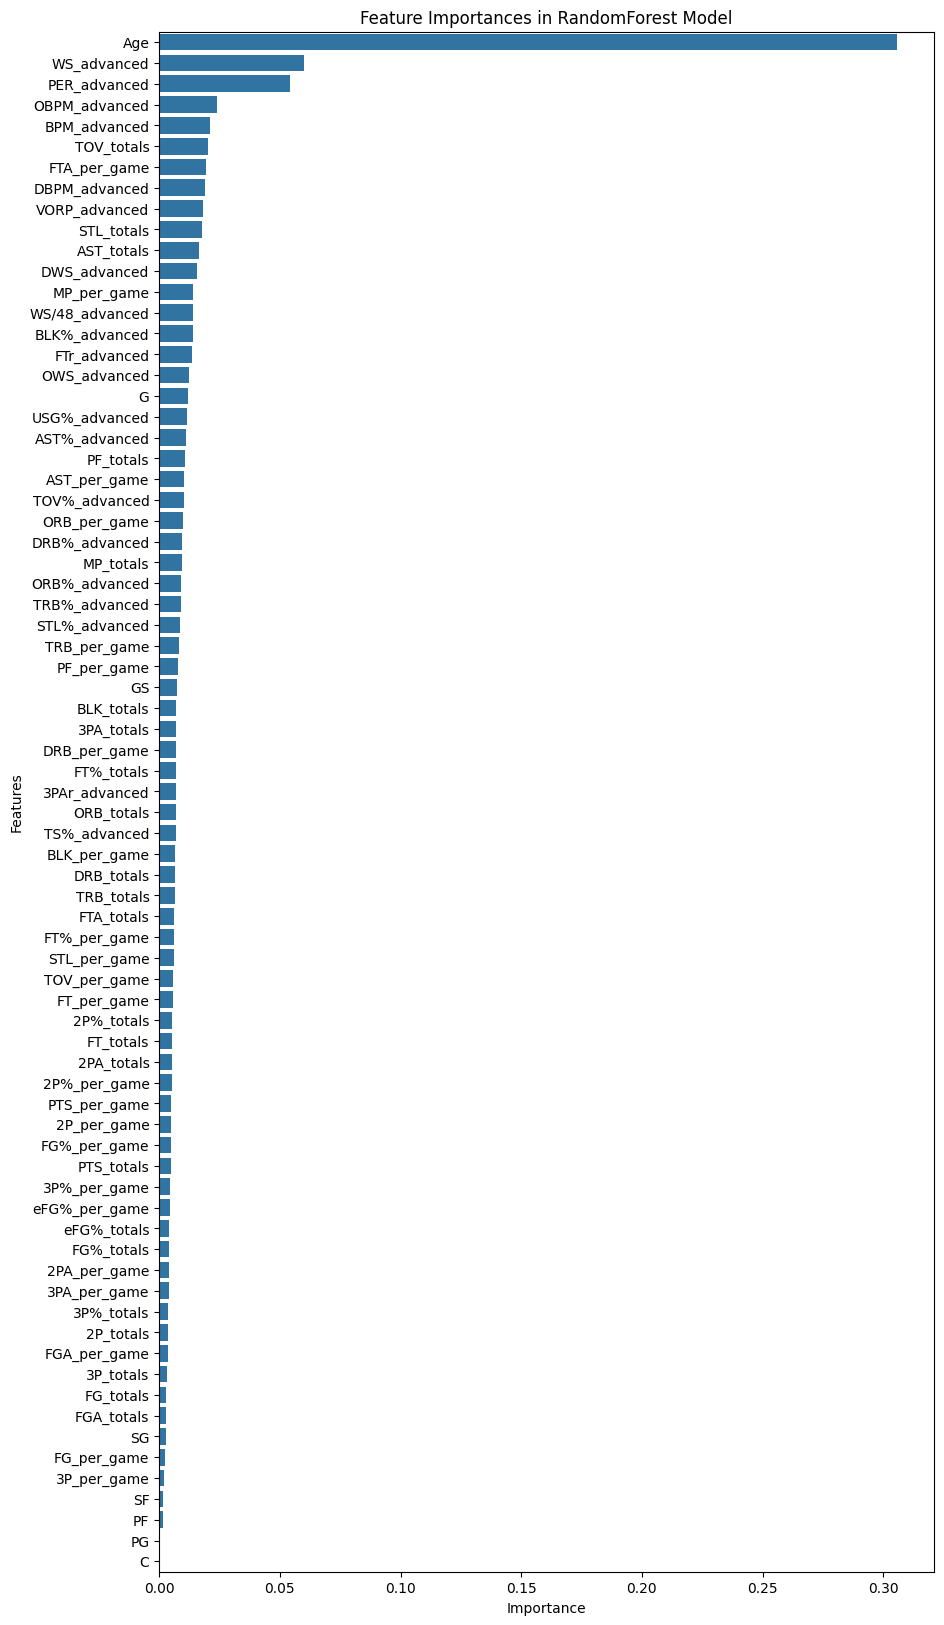

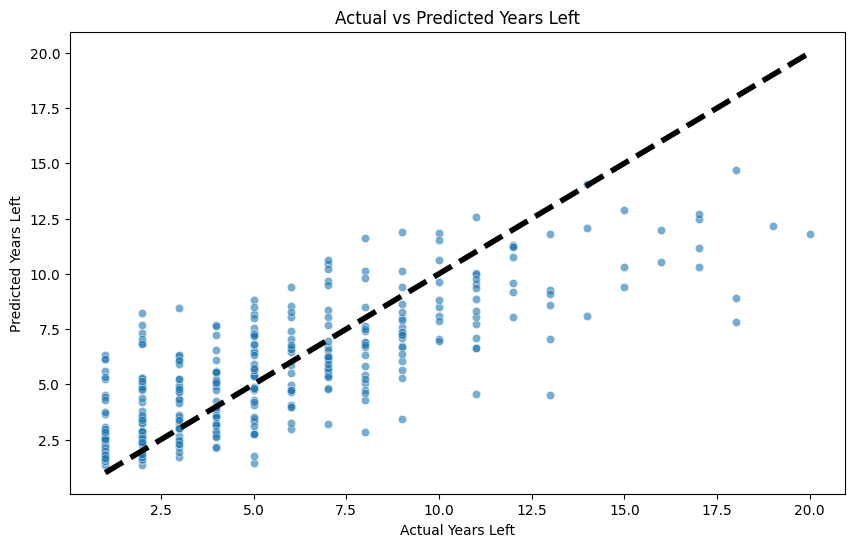

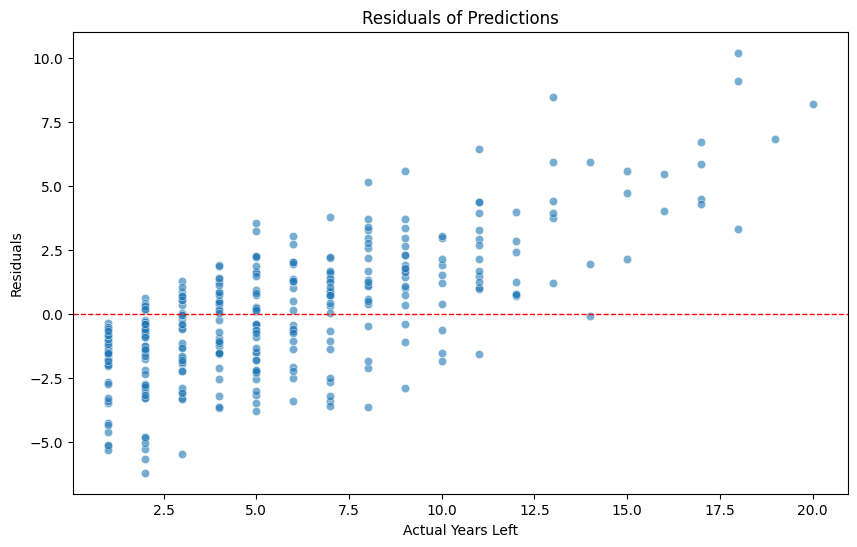

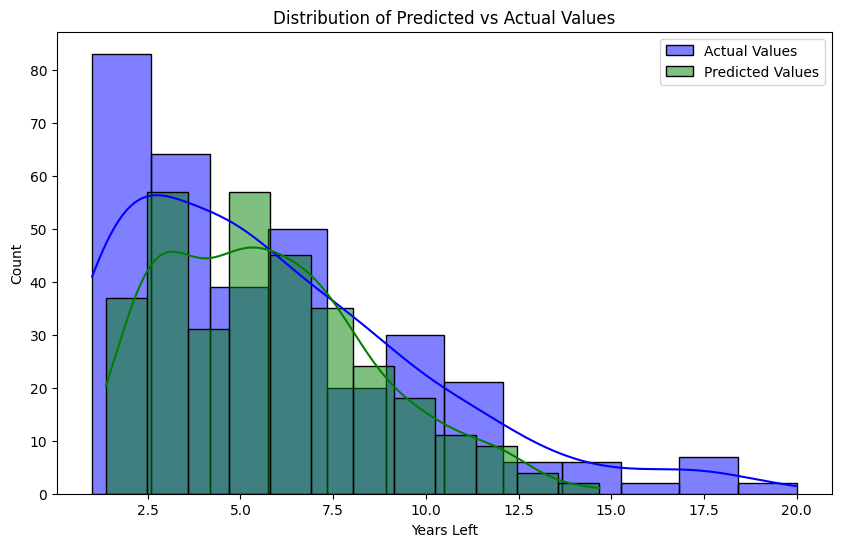

In [11]:
# Feature Importances Plot
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# 2. Actual vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Line showing perfect predictions
plt.title('Actual vs Predicted Years Left')
plt.xlabel('Actual Years Left')
plt.ylabel('Predicted Years Left')
plt.show()

# 3. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.title('Residuals of Predictions')
plt.xlabel('Actual Years Left')
plt.ylabel('Residuals')
plt.show()

# Distribution of Predicted vs Actual Values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color="blue", label='Actual Values', kde=True)
sns.histplot(y_pred, color="green", label='Predicted Values', kde=True)
plt.title('Distribution of Predicted vs Actual Values')
plt.xlabel('Years Left')
plt.legend()
plt.show()